# 1. Vector Space Model of Word Meaning

The goal of this problem set is to make you familiar with vector space model of word meaning. You may reuse some of functions you coded in Assignment 1. 

### Warning: This assignment may take substantial time to run if you are not optimizing your code. Make sure you have plenty of time to run if you are new to programming.

Go to https://drive.google.com/drive/folders/1Pe6D713L9S0GWwb_XzeLXAeNZOrBqZaN?usp=sharing and click add shortcut to drive. This will add the data required for this problem set to your Google drive.

<img src="https://drive.google.com/uc?id=1LqHisiziX8Ri94Xs6Cv8mhx6vivFM3kS" alt="Drawing" height="300"/>

Caution: Since this is real language on Twitter and deals with current events, some of it could be disturbing. In the later section of the course, we will deal with ethics and what is appropriate and what is not. 



Run the below code snippet. It will generate a URL which generates an authorization code.* Enter it below to give Colab access to your Google drive. 

*Copy function may not work. If so, manually copy the authorization code.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


When you run the `ls` command below, you should see the files in the tweets folder.

> Indented block






In [2]:
!ls "/content/drive/My Drive/tweets"

20000_tweets.jsonl
20000_tweets.txt
covid-tweets-2020-08-10-2020-08-21.tokenized.txt
covid-tweets-2020-08-10-2020-08-21.trigrams.txt
GoogleNews-vectors-negative300.bin.gz
stop_words.txt


In [3]:
# let's read tweets. These tweets are already tokenized and cleaned (Assignment 1)
tweets = open("/content/drive/My Drive/tweets/covid-tweets-2020-08-10-2020-08-21.tokenized.txt", "r").read().split("\n")
tweets = [tweet.split() for tweet in tweets]

print(len(tweets))


312878


## Problem 1.1: Word space model

Compute the most important context words of `ventilator`. Use Pointwise Mutual Information (PMI) to rank the context words (Refer to Lecture 4).

We define context as up to 3 words to the left and 3 words to the right. Ignore stop words and words that do not start with [a-z#]. Also ignore words that are not in the top 1000 frequent words.

These context words define the dimensions of the vector space model. Represent each word as a vector (dictionary/counter) of context words with PMI as the importance of the context word. Print the top 20 context words for each.

This is the sample output I got for `ventilator`. Your numbers need not match mine but the ranked list should look close to what I have.

```
[('put', 18.280538283196606), ('wearing', 17.587373569812726), ('even', 17.58651933524197), ('like', 17.402738298715878), ('covid', 17.172590097063086), ('patients', 16.894419647496004), ('use', 16.894298589380956), ('die', 16.89426559608771), ('days', 16.89415252713107), ('needed', 16.489137134110106), ('month', 16.48907033839664), ('weeks', 16.488913820220848), ('away', 16.48879303327717), ('week', 16.488739054051933), ('person', 16.488678720881293), ('good', 16.488160838026904), ('deaths', 16.487822204799755), ('go', 16.487564042558112), ('would', 16.48707075078768), ('one', 16.48706217686235), ('get', 16.486565870239033)]
```



Let's first load stop words.

In [4]:
stop_words = set()
def load_stop_words():
  words = open("/content/drive/My Drive/tweets/stop_words.txt", "r").read().split("\n")
  for word in words:
    stop_words.add(word.strip())

load_stop_words()
print(len(stop_words))
print(stop_words)

134
{'doing', 'here', 'such', 'their', 'down', 'only', 'above', 'me', 'yourselves', 'then', 'you', 'with', 'by', 'my', 'and', 'than', 'whom', 'to', 't', 'i', 'during', 'again', 'once', 'each', '@USER', 'our', 'myself', 'these', "'ld", 'why', 'more', 'who', "'ve", 'other', 'are', 'up', 'is', 'which', 'yourself', 'will', 'hers', 'on', 'because', 'or', 'below', 'until', 'further', 'being', 'through', 'while', 'had', 'under', 'don', 'were', 'your', 'what', 'same', 'having', 'they', 'the', 'should', 'any', 'its', 'ours', 'an', 'just', 'over', 'she', 'how', 'himself', 'own', 'URL', 'from', 'be', 'where', "n't", 'into', 'he', 'of', 'so', 'as', 'ourselves', 'it', 'very', 'theirs', 'out', 'both', 'few', 'now', 'herself', 'too', 's', 'for', 'against', 'some', "'ll", 'itself', 'but', 'those', 'have', 'a', 'has', 'when', 'all', 'amp', 'that', 'do', 'yours', 'there', 'we', 'off', 'nor', 'not', 'after', 'her', 'most', 'am', 'this', 'did', 'before', 'between', 'his', 'at', 'them', 'him', 'about', 'do



```
# This is formatted as code
```

Let's build the word vectors

In [5]:
from collections import Counter
from itertools import combinations
from math import log
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pformat
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, norm
from nltk.util import skipgrams
from string import punctuation
from scipy import sparse
from scipy.sparse import linalg
import re
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
stemmer= PorterStemmer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
unigram_counts = Counter()
skipgram_counts = Counter()
x2i, i2x = {}, {}

tweets_trimmed = [[token for token in tweet if token not in stop_words and (re.match(r"[a-z#]+", token[0]))] for tweet in tweets]

In [11]:
def compute_unigrams():
  global unigram_counts
  unigram_counts = Counter()
  for idx, tweet in enumerate(tweets_trimmed):
    for token in tweet:
      unigram_counts[token] += 1

  # Remove all unigrams in in top 1000
  most_common_unigram = unigram_counts.most_common(1000)
  for k,v in list(unigram_counts.copy().items()):
    if (k,v) not in most_common_unigram:
      del unigram_counts[k]
  print('Most common unigram: {}'.format(unigram_counts.most_common(10)))
  print('Trimmed vocab size should be 1000: {}'.format(len(unigram_counts)))

compute_unigrams()

Most common unigram: [('covid', 71281), ('pandemic', 50353), ('covid-19', 33591), ('people', 31850), ('n’t', 31053), ('like', 20837), ('mask', 20107), ('get', 19982), ('coronavirus', 19949), ('trump', 19223)]
Trimmed vocab size should be 1000: 1000


In [12]:
def compute_skip_grams():
  global skipgram_counts
  for idx, tweet in enumerate(tweets_trimmed):
      # 3 words left and right
      skip_gram = list(skipgrams(tweet, 2, 3))
      for context in skip_gram:
        skipgram_counts[context] += 1

  print('Skipgram size: {}'.format(len(skipgram_counts)))
  print('Most common skipgrams: {}'.format(skipgram_counts.most_common(10)))

compute_skip_grams()

Skipgram size: 6209898
Most common skipgrams: [(('wear', 'mask'), 11991), (('social', 'distancing'), 6776), (('stay', 'home'), 6009), (('ca', 'n’t'), 4990), (('new', 'cases'), 4106), (('gon', 'na'), 2887), (('cases', 'deaths'), 2547), (('people', 'covid'), 2362), (('get', 'covid'), 2358), (('covid', 'n’t'), 2278)]


In [15]:
def matrix_word(words):
  f = np.hstack(words)
  freq = Counter(f)
  top_freq = sorted(list(freq.items()), key=lambda x: x[1], reverse=True)[:1000]
  index_word = {top_freq[i][0]: i for i in range(len(top_freq))}

  return freq, index_word
freq, index_word = matrix_word(tweets_trimmed)

In [14]:
tot_words = 0
for tweet in tweets_trimmed:
  tot_words += len(tweet)

In [23]:
from math import log

def PMI(word1, word2, join_freq):
  # Write your code
  cx = freq[word1]
  cy = freq[word2]
  cxy = join_freq[index_word[word2]] * tot_words

  if cxy:
    return log(cxy / cx / cy)
  return 0
 
def build_word_vector(word):
  # Write your code 
  join_freq = [0] * 1000 
  for tweet in tweets_trimmed:
    if word not in tweet:
      continue
    for ind in range(len(tweet)):
      if tweet[ind] != word:
        continue
      for dx in range(ind -3, ind+4):
        if (dx >= 0 and dx < len(tweet) and dx != ind) and (tweet[dx] in index_word.keys()):
          join_freq[index_word[tweet[dx]]] += 1
  for k in index_word.keys():
    join_freq[index_word[k]] = PMI(word, k, join_freq)
  
  return join_freq

def print_top_dimensions(word_vector, n):
  # print top n dimensions sorted in the order of importance.
  rev_idx = {v: k for k, v in index_word.items()}
  word_vector_pro = {rev_idx[i]: word_vector[i] for i in range(len(word_vector))}
  sorted_word_vec = sorted(list(word_vector_pro.items()), key=lambda x: x[1], reverse=True)
  print(sorted_word_vec[:n])


v1 = build_word_vector('ventilator')
print_top_dimensions(v1, 20) # print top 20 dimensions along with their weights

[('patient', 5.411850239784782), ('hospital', 4.743324143615185), ('patients', 4.667741462449178), ('put', 4.591270340211511), ('spent', 4.318976847785691), ('enjoy', 4.282249556065533), ('tried', 4.268475233600704), ('loved', 4.217797723844838), ('end', 4.202171285881991), ('brain', 4.162157583802672), ('critical', 4.121187998698428), ('increase', 4.100737388227137), ('needed', 4.042872328676352), ('days', 4.031582586531751), ('month', 4.028779954536644), ('experience', 4.00853419109546), ('weeks', 3.9578036429242243), ('failure', 3.928491483421924), ('k', 3.8113217123362664), ('wearing', 3.643490704471721)]


## Problem 1.2: Compute the word similarity between words using Cosine Similarity.

Compute cosine similarity between the following pair of words: 
```
('ventilator', 'covid-19')
('ventilator', 'lockdown')
('ventilator', 'mask')
('ventilator', 'ppe')
```

Outputs of my code are:
```
('ventilator', 'covid-19') 0.17076006036635358
('ventilator', 'lockdown') ...
('ventilator', 'mask') 0.19229601085517933
('ventilator', 'ppe') ...
```


In [25]:
ventilator = build_word_vector('ventilator')
covid19 = build_word_vector('covid-19')
lockdown = build_word_vector('lockdown')
mask = build_word_vector('mask')
ppe = build_word_vector('ppe')

In [29]:
from numpy import linalg as LNG 
import numpy as np

def cosine_similarity(vector1, vector2):
  cos, cxy, cx, cy = 0, 0, 0, 0

  for i in range(len(vector1)):
    cx += vector1[i] ** 2
    cy += vector2[i] ** 2
    cxy += vector1[i] * vector2[i]
  cos = cxy/(cx + cy)
  return cos

print(('ventilator', 'covid-19'), cosine_similarity(ventilator, covid19))
print(('ventilator', 'lockdown'), cosine_similarity(ventilator, lockdown))
print(('ventilator', 'mask'), cosine_similarity(ventilator, mask))
print(('ventilator', 'ppe'), cosine_similarity(ventilator, ppe))

('ventilator', 'covid-19') 0.21577910124582148
('ventilator', 'lockdown') 0.21327248533218487
('ventilator', 'mask') 0.1822954530789848
('ventilator', 'ppe') 0.1884722830013833


## Problem 1.3: What can you tell about these words from the similarities?

1. `ventilator` when compared with `covid-19, lockdown, mask, ppe`
2. `pandemic` when compared with `covid-19, lockdown, mask, ppe`
3. `president` compared with `trump, biden`
4. `trudeau` compared with `trump, biden`



In [31]:
ventilator = build_word_vector('ventilator')
pandemic = build_word_vector('pandemic')
president = build_word_vector('president')
trudeau = build_word_vector('trudeau')

covid19 = build_word_vector('covid-19')
lockdown = build_word_vector('lockdown')
mask = build_word_vector('mask')
ppe = build_word_vector('ppe')
trump = build_word_vector('trump')
biden = build_word_vector('biden')


print(('ventilator', 'covid-19'), cosine_similarity(ventilator, covid19))
print(('ventilator', 'lockdown'), cosine_similarity(ventilator, lockdown))
print(('ventilator', 'mask'), cosine_similarity(ventilator, mask))
print(('ventilator', 'ppe'), cosine_similarity(ventilator, ppe))
print()
print(('pandemic', 'covid-19'), cosine_similarity(pandemic, covid19))
print(('pandemic', 'lockdown'), cosine_similarity(pandemic, lockdown))
print(('pandemic', 'mask'), cosine_similarity(pandemic, mask))
print(('pandemic', 'ppe'), cosine_similarity(pandemic, ppe))
print()
print(('president', 'trump'), cosine_similarity(president, trump))
print(('president', 'biden'), cosine_similarity(president, biden))
print()
print(('trudeau', 'trump'), cosine_similarity(trudeau, trump))
print(('trudeau', 'biden'), cosine_similarity(trudeau, biden))

('ventilator', 'covid-19') 0.21577910124582148
('ventilator', 'lockdown') 0.21327248533218487
('ventilator', 'mask') 0.1822954530789848
('ventilator', 'ppe') 0.1884722830013833

('pandemic', 'covid-19') 0.41007794642634
('pandemic', 'lockdown') 0.4251049786200557
('pandemic', 'mask') 0.3526730125403971
('pandemic', 'ppe') 0.3180970573197574

('president', 'trump') 0.4537076610848569
('president', 'biden') 0.41620554983315994

('trudeau', 'trump') 0.2673053910979366
('trudeau', 'biden') 0.2533337977801984


1. 'covid-19', 'lockdown', 'mask' and 'ppe' are equivalently close to the context word 'ventilator' but 'covid-19' and 'lockdown' are slighlty closer
2. Here, we notice that 'ppe' is the least relevant to 'pandemic' since it has the smallest cosine similarity whereas 'covid-19', 'lockdown' and 'mask' are all relatively close to each other.
3. 'trump' and 'biden' are equivalently close to the context word 'president'
4. 'trump' and 'biden' are equivelently close to the context word' trudeau' and more than 'president'

# Let's play with word2vec

First let's load word2vec. I am using [gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) but feel free to use any libraries or tools.

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = '/content/drive/My Drive/tweets/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

## Problem 1.4: Compute the top 5 similar words of `ventilator` using word2vec?

---



In [2]:
# Write your code here
word2vec.most_similar(['ventilator'] , topn = 5)

[('respirator', 0.7864563465118408),
 ('mechanical_ventilator', 0.7063840627670288),
 ('intensive_care', 0.6809945702552795),
 ('ventilators', 0.6683582067489624),
 ('breathing_tube', 0.6665509343147278)]

# Problem 1.5: Word analogy

If I told you the plural of `car` is `cars`, can you automatically find the plural of `hypothesis` and `man` using word2vec.

Similarly, if I told you a newborn `dog` is called `puppy`, can you automatically find what are the newborn words of `cat` and `sheep` using word2vec?


In [4]:
print(word2vec.most_similar(positive=['hypothesis','cars'], negative=['car'] )[0][0])
print(word2vec.most_similar(positive=['man','cars'], negative=['car'] )[0][0])

print(word2vec.most_similar(positive=['cat','puppy'], negative=['dog'] )[0][0])
print(word2vec.most_similar(positive=['sheep','puppy'], negative=['dog'] )[0][0])

hypotheses
men
kitten
lambs


# 2. Topic Models 

The goal of this part is to make you familiar with topic models. You may reuse some of functions you coded for the previous assignments.

## Data Download and Setup

Let us start by downloading the news section of the Brown corpus:

In [1]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
documents = [brown.words(fileid) for fileid in brown.fileids()]

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


Let us inspect some of the documents:

In [2]:
print("The news section of the Brown corpus contains {} documents.".format(len(documents)))
for i in range(3):
  document = documents[i]
  print("Document {} has {} words: {}".format(i, len(document), document))

The news section of the Brown corpus contains 500 documents.
Document 0 has 2242 words: ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]
Document 1 has 2277 words: ['Austin', ',', 'Texas', '--', 'Committee', 'approval', ...]
Document 2 has 2275 words: ['Several', 'defendants', 'in', 'the', 'Summerdale', ...]


Finally, let us download a list of stopwords for later.

In [5]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')
print(stopwords_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

## Problem 2.1: Document-Term Matrix

Create a document-term matrix with tf-idf. You should preprocess documents by: 1) lowercasing words, 2) excluding stopwords, and 3) including alphanumeric strings only.

```python
import numpy as np
def create_tfidf_matrix(documents: List[List[str]]) -> (np.array, List[str]):
  # Args:
  #   documents: list of documents, each document being a list of words.
  # Outputs:
  #   tfidf_matrix: np.array of shape (num_documents, vocabulary_size)
  #   vocabulary: a list of terms corresponding to the columns of the matrix.

tfidf_matrix, vocabulary = create_tfidf_matrix(documents)
```

How sparse is this matrix? Calculate the ratio between cells with value 0 and the total number of cells. 


In [10]:
import re
from typing import List

def preprocess(documents: List[List[str]]):
  return_docs = []
  documents_processed = [[token.lower() for token in document if token not in stopwords_list and token.isalnum()] for document in documents]
  return documents_processed
  
documents_processed = preprocess(documents)

In [11]:
def compute_word_set(documents):
  wordset = set()
  for document in documents:
    wordset = wordset.union(set(document))
  return wordset

wordset = compute_word_set(documents_processed)

In [12]:
def compute_word_dict(documents):
  global wordset
  word_dict_list = []
  for document in documents:
    word_dict = dict.fromkeys(wordset, 0)
    for word in document:
      word_dict[word] += 1
    word_dict_list.append(word_dict)
  return word_dict_list

word_dict_list = compute_word_dict(documents_processed)

In [13]:
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict.items():
        tfDict[word] = count/float(bowCount)
    return tfDict

tf = []
for idx, doc in enumerate(documents_processed):
  tf.append(computeTF(word_dict_list[idx], doc))

In [14]:
def computeIDF(docList):
    import math
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

idfs = computeIDF(tf)

In [15]:
def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

tfidf = []
for i in tf:
  tfidf.append(computeTFIDF(i, idfs))

In [16]:
import pandas as pd
import numpy as np

def create_tfidf_matrix(documents: List[List[str]]) -> (np.array, List[str]):
  # Args:
  #   documents: list of documents, each document being a list of words.
  # Outputs:
  #   tfidf_matrix: np.array of shape (num_documents, vocabulary_size)
  #   vocabulary: a list of terms corresponding to the columns of the matrix.

  global tfidf
  tfidfDF = pd.DataFrame(tfidf)
  tfidf_matrix = pd.DataFrame(tfidfDF).to_numpy()
  voc = list(tfidfDF.columns.values)
  return (tfidf_matrix, voc)

tfidf_matrix, vocabulary =  create_tfidf_matrix(documents_processed)
sparsity = 1.0 - ( np.count_nonzero(tfidf_matrix) / float(tfidf_matrix.size) )
print("Sparcity of a matrix is {}".format(sparsity))

Sparcity of a matrix is 0.983964396322579


## Problem 2.2: Latent Semantic Analysis

We perform LSA to obtain document embeddings `U` and term embeddings `VT`.

```python
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(tfidf_matrix, 
                              n_components=10,
                              n_iter=100,
                              random_state=42)
```

Define a function to find the 5 most relevant terms for each of the 10 latent dimensions (tip: you should make use of VT and the vocabulary).

```python
def extract_salient_words(VT: np.array, 
                  vocabulary: List[str]
                  ) -> salient_words: dict[int, List[str]]:
  # Args:
  #  VT: a numpy array of size (n_components, vocabulary_size)
  #  vocabulary: a list of words of size vocabulary_size
  # Outputs:
  #  salient_words: a dictionary with the latent dimension indices as keys and a list of its 5 most salient words as values

salient_words = extract_salient_words(VT, vocabulary)

for key, value in salient_words:
  print("Concept {}: {}".format(str(key), " ".join(value)))
```

In [8]:
#############################################
############ TO BE REMOVED ##################
#############################################
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

import re
from typing import List

def preprocess(documents: List[List[str]]):
  return_docs = []
  documents_processed = [[token.lower() for token in document if token not in stopwords_list and token.isalnum()] for document in documents]
  for doc in documents_processed:
    return_docs.append(' '.join(doc))

  return return_docs

documents_processed = preprocess(documents)
def create_tfidf_matrix(documents: List[List[str]]) -> (np.array, List[str]):
  vectorizer = TfidfVectorizer()
  doc_vec = vectorizer.fit_transform(documents)
  tfidf_df = pd.DataFrame(doc_vec.toarray(), columns = vectorizer.get_feature_names())
  tfidf_matrix = tfidf_df.to_numpy()
  voc = list(tfidf_df.columns.values)
  return (tfidf_matrix, voc)

tfidf_matrix, vocabulary = create_tfidf_matrix(documents_processed)

#############################################
###########^  TO BE REMOVED ^ ################
#############################################

In [9]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(tfidf_matrix, 
                              n_components=10,
                              n_iter=100,
                              random_state=42)

In [10]:
from typing import List, Dict
import numpy as np

def extract_salient_words(VT: np.array, vocabulary: List[str]) -> Dict[int, List[str]]:
  salient_words: Dict[int, List[str]] = {}
  for i in range(len(VT)):
    tfidf_sorting = np.argsort(VT[i]).flatten()[::-1]
    n = 5
    voc = np.array(vocabulary)
    top_n = voc[tfidf_sorting]
    salient_words[i] = top_n[:n].tolist()
  return salient_words

salient_words = extract_salient_words(VT, vocabulary)
for key, value in salient_words.items():
  print("Concept {}: {}".format(str(key), " ".join(value)))

Concept 0: the he one said would
Concept 1: he she said back like
Concept 2: af shear temperature anode tangent
Concept 3: life human god experience literature
Concept 4: af he nations soviet united
Concept 5: af music the john kennedy
Concept 6: school church education college said
Concept 7: god church christ him jesus
Concept 8: he the students education college
Concept 9: he state court federal tax


## Problem 2.3: Document Retrieval

Given a text query, view this as a mini document, and compare it to your documents in the low-dimensional space.

First, we need to map a query into a pseudo-document embedding.
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ed5d0397ee6b44f72f77743029d3943932118fa2" alt="Query" height="35"/>

Then, you will need to implement a function to calculate the cosine similarity between this embedded query and all the document embeddings.

Retrieve the indices of the top-3 documents with the highest cosine similarity with the following queries:


```python
query1 = ['T.', 'V.', 'Barker', 'developed', 'the', 'classification-angle', 'system']
query2 = ['imitation', 'vs.', 'formalism' 'in', 'philosophical', 'debates']
query3 = ['Krim', 'attended', 'the', 'University', 'of', 'North', 'Carolina', 'to', 'follow', 'Thomas', 'Wolfe']
```



## Problem 2.4: Document Clustering

```python
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
document_embeddings = U * Sigma
km.fit(document_embeddings)
clusters = km.labels_.tolist()
print(clusters)
```

Let us now plot the document embeddings and their clusters:

```python
import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()
```

What are the differences you observe by using a different number of `n_components` in LSA or `n_clusters` in K-Means?

In [19]:
!pip uninstall umap
!pip install umap-learn

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import umap

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
document_embeddings = U * Sigma
km.fit(document_embeddings)
clusters = km.labels_.tolist()
print(clusters)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 1, 2, 2, 2, 2, 2, 0, 2, 6, 2, 2, 2, 5, 2, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 8, 0, 2, 2, 2, 2, 2, 2, 

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


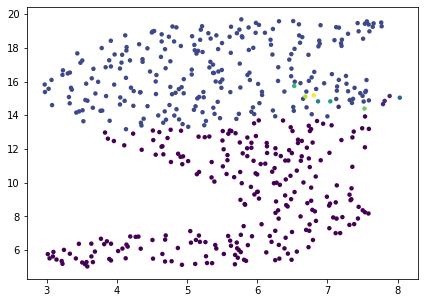

In [21]:
import umap
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()

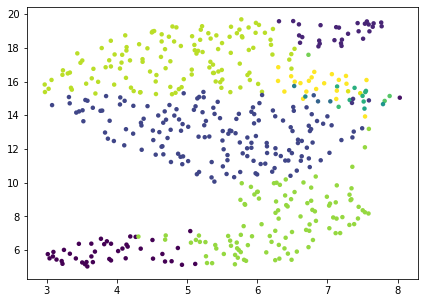

In [22]:
num_clusters = 20
km = KMeans(n_clusters=num_clusters)
document_embeddings = U * Sigma
km.fit(document_embeddings)
clusters = km.labels_.tolist()
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()

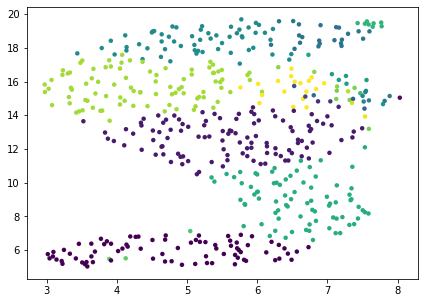

In [23]:
num_clusters = 30
km = KMeans(n_clusters=num_clusters)
document_embeddings = U * Sigma
km.fit(document_embeddings)
clusters = km.labels_.tolist()
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()

In [ ]:
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5, random_state=42).fit_transform(document_embeddings)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, s=20, edgecolor='none')
plt.show()

## Problem 2.5 Latent Dirichlet Allocation

Run LDA on `documents` using `sklearn` (find the documentation at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation))

Make sure to specify `random_state=42` for replicability. 

What are the topics allocated to each word of document number 13? 

In [ ]:
print(documents[13])

In [ ]:
# Write your code here.
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification


X, _ = make_multilabel_classification(random_state=0)
lda = LatentDirichletAllocation(n_components=5, random_state=42)

lda.fit(X)